In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load a grayscale image
image_path = 'img1.jpg'  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Step 2: Apply Gaussian Smoothing
# This reduces noise and smoothens the image
smoothed_image = cv2.GaussianBlur(image, (5, 5), 1.4)

# Step 3: Calculate gradients using Sobel filters
# Compute gradients along the x and y directions
gradient_x = cv2.Sobel(smoothed_image, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(smoothed_image, cv2.CV_64F, 0, 1, ksize=3)

# Calculate the magnitude and direction of gradients
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_magnitude = (gradient_magnitude / gradient_magnitude.max()) * 255  # Normalize to 0-255
gradient_direction = np.arctan2(gradient_y, gradient_x)

# Step 4: Non-Maximum Suppression
def non_maximum_suppression(gradient_magnitude, gradient_direction):
    rows, cols = gradient_magnitude.shape
    suppressed = np.zeros((rows, cols), dtype=np.float32)
    angle = gradient_direction * 180 / np.pi  # Convert radians to degrees
    angle[angle < 0] += 180

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # Determine the two pixels to compare
            q, r = 255, 255  # Default high values
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = gradient_magnitude[i, j + 1]
                r = gradient_magnitude[i, j - 1]
            elif 22.5 <= angle[i, j] < 67.5:
                q = gradient_magnitude[i - 1, j + 1]
                r = gradient_magnitude[i + 1, j - 1]
            elif 67.5 <= angle[i, j] < 112.5:
                q = gradient_magnitude[i - 1, j]
                r = gradient_magnitude[i + 1, j]
            elif 112.5 <= angle[i, j] < 157.5:
                q = gradient_magnitude[i - 1, j - 1]
                r = gradient_magnitude[i + 1, j + 1]

            # Suppress non-maximum pixels
            if gradient_magnitude[i, j] >= q and gradient_magnitude[i, j] >= r:
                suppressed[i, j] = gradient_magnitude[i, j]
            else:
                suppressed[i, j] = 0
    return suppressed

nms_image = non_maximum_suppression(gradient_magnitude, gradient_direction)

# Step 5: Apply thresholding (Hysteresis Thresholding for final edges)
# Use OpenCV's built-in Canny for comparison
low_threshold = 50
high_threshold = 150
final_edges = cv2.Canny(image, low_threshold, high_threshold)

# Step 6: Display Results
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis("off")

# Smoothed Image
plt.subplot(2, 3, 2)
plt.title("Smoothed Image")
plt.imshow(smoothed_image, cmap='gray')
plt.axis("off")

# Gradient Magnitude
plt.subplot(2, 3, 3)
plt.title("Gradient Magnitude")
plt.imshow(gradient_magnitude, cmap='gray')
plt.axis("off")

# Non-Maximum Suppression
plt.subplot(2, 3, 4)
plt.title("Non-Maximum Suppression")
plt.imshow(nms_image, cmap='gray')
plt.axis("off")

# Final Edges (Canny Output)
plt.subplot(2, 3, 5)
plt.title("Canny Edge Detection")
plt.imshow(final_edges, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


<ipython-input-10-e0e518e3d98c>:32: RuntimeWarning: overflow encountered in scalar subtract
  if abs(current_intensity - seed_intensity) <= threshold:


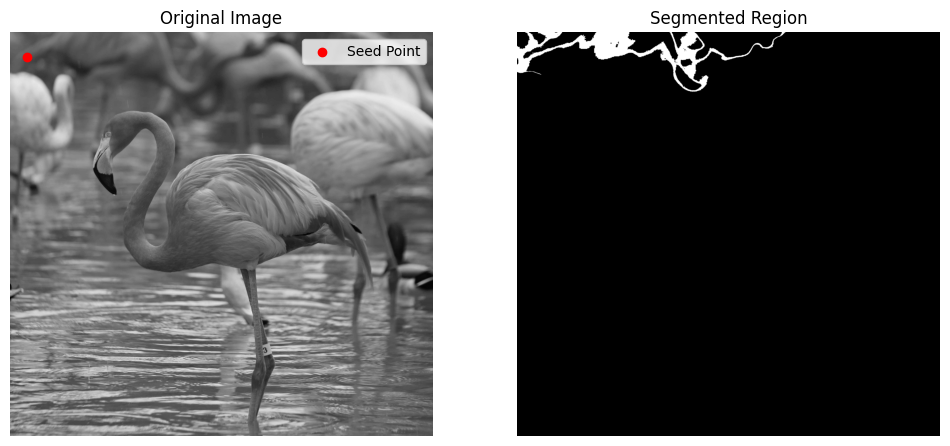

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def region_growing(image, seed_point, threshold=10):
    """
    Perform region growing segmentation.
    Args:
    - image: Input grayscale image
    - seed_point: Tuple (x, y) representing the seed point
    - threshold: Intensity difference threshold for region growing

    Returns:
    - segmented_image: Binary mask of the segmented region
    """
    # Get image dimensions
    height, width = image.shape

    # Create a binary mask for the segmented region
    segmented_image = np.zeros_like(image, dtype=np.uint8)

    # Create a list to store pixels to be checked
    stack = [seed_point]

    # Get the intensity value of the seed point
    seed_intensity = image[seed_point[1], seed_point[0]]

    while stack:
        x, y = stack.pop()
        if segmented_image[y, x] == 0:  # If not already visited
            current_intensity = image[y, x]
            if abs(current_intensity - seed_intensity) <= threshold:
                segmented_image[y, x] = 255  # Mark as segmented

                # Add neighbors to the stack
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < width and 0 <= ny < height:
                        stack.append((nx, ny))
    return segmented_image

# Step 1: Load an image
image_path = 'img1.jpg'  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Step 2: Select a seed point manually
seed_point = (100, 150)  # Replace with your chosen seed point (x, y)

# Step 3: Apply region growing
segmented_image = region_growing(image, seed_point, threshold=15)

# Step 4: Visualize the results
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap="gray")
plt.scatter([seed_point[0]], [seed_point[1]], color="red", label="Seed Point")  # Highlight seed point
plt.legend()
plt.axis("off")

# Segmented region
plt.subplot(1, 2, 2)
plt.title("Segmented Region")
plt.imshow(segmented_image, cmap="gray")
plt.axis("off")

plt.show()
